In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'

color_list = [CB91_Blue, CB91_Pink, CB91_Green, CB91_Amber,
              CB91_Purple, CB91_Violet]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)


#Validation croisée pour les k plus proches voisins

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import numpy as np
import math

def risk(y_hat, y):
  sum = 0
  for i in range(len(y)):
    sum = sum + (y_hat[i]-y[i])**2
  return((1/len(y))*sum)

def cross_validation_k_neighbors(X_train, y_train):
  n_max = min(40, len(X_train))      #nombre maximum de voisins testé
  k_star = 1
  neighbors = KNeighborsRegressor(n_neighbors=1)
  error = math.inf
  n = len(X_train)
  for k in range(1, n_max+1):
    estimator = []
    neighbors = KNeighborsRegressor(n_neighbors=k)
    for j in range(n):
      X_tab = np.delete(X_train, [j])
      y_tab = np.delete(y_train, [j])
      neighbors.fit(X_tab.reshape(n-1, 1), y_tab)
      estimator.append(neighbors.predict(X_train[j].reshape(1,1)))
    error2 = risk(estimator, y_test)
    if (error2 < error):
      error = error2
      k_star = k
  return k_star


#Implémentation de l'estimateur des k plus proches voisins à l'aide de **sklearn.neighbors**

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import numpy as np


def k_neighbors_predictor(X_train, y_train, X_test):
  k_opt = cross_validation_k_neighbors(X_train, y_train)
  k1 = 3
  k2 = 10
  
  #Fitting KNR with k_opt neighbors
  neighbors = KNeighborsRegressor(n_neighbors=k_opt)
  neighbors.fit(X_train.reshape(len(X_train), 1), y_train)
  #Predicting
  y_opt = neighbors.predict(X_test.reshape(len(X_test), 1))

  neighbors = KNeighborsRegressor(n_neighbors=k1)
  neighbors.fit(X_train.reshape(len(X_train), 1), y_train)
  y1 = neighbors.predict(X_test.reshape(len(X_test), 1))

  neighbors = KNeighborsRegressor(n_neighbors=k2)
  neighbors.fit(X_train.reshape(len(X_train), 1), y_train)
  y2 = neighbors.predict(X_test.reshape(len(X_test), 1))

  return (y_opt, y1, y2)


#Implémentation de l'estimateur à noyau de Nadaraya-Watson (avec validation croisée)

In [ ]:
import math
import matplotlib as mpl

def gaussian_kernel(x):
  return((1/(math.sqrt(2*math.pi)))*math.exp(-0.5*x**2))

def calcul_f_hat_i(i, X, y, bandwidth):
  denominator = 0
  for j in range(len(X)):
    if j!=i:
      denominator = denominator + gaussian_kernel((X[i]-X[j])/bandwidth)  
  numerator = 0
  for j in range(len(X)):
    if j!=i:
      numerator = numerator + gaussian_kernel((X[i]-X[j])/bandwidth)*y[j]
  if denominator !=0:
    return(numerator/denominator)
  return 0

def error_cross_validation(X, y, bandwidth):
  n = len(X)
  result = 0
  for i in range(n):
    result = result + math.pow(calcul_f_hat_i(i, X, y, bandwidth)-y[i], 2)
  return result/n

#calcul h_opt
def kernel_cross_validation(X, y):
  h_opt = 0.1
  opt = error_cross_validation(X, y, h_opt)
  h = 0.2
  while h<2.5:
    tmp = error_cross_validation(X, y, h)
    if (tmp < opt):
      h_opt = h
      opt = tmp
    h = h + 0.1
  return h_opt


#calcul estimateur à noyau pour un x donné
def kernel_nadaraya_watson(x, X_train, y_train, bandwidth):
  denominator = 0
  for i in range(len(X_train)):
    denominator = denominator + gaussian_kernel((x-X_train[i])/bandwidth)
  numerator = 0
  for i in range(len(X_train)):
    numerator = numerator + gaussian_kernel((x-X_train[i])/bandwidth)*y_train[i]
  if denominator != 0:
    return(numerator/denominator)
  return 0



def Kernel_Regression(X_train, y_train, X_test):
  h_opt = kernel_cross_validation(X_train, y_train)
  h1 = 1
  h2 = 1.5
  
  estimator_opt = []
  estimator1 = []
  estimator2 = []

  for i in range(len(X_test)):
    estimator_opt.append(kernel_nadaraya_watson(X_test[i], X_train, y_train, h_opt))
    estimator1.append(kernel_nadaraya_watson(X_test[i], X_train, y_train, h1))
    estimator2.append(kernel_nadaraya_watson(X_test[i], X_train, y_train, h2))

  return (estimator_opt, estimator1, estimator2)




#Implémentation de l'estimateur par projection de Nadaraya-Watson (**D=20**)

In [ ]:
import math
import matplotlib as mpl
import numpy as np

#numero : 1
def base_histogrammes(x, j, a, b, D):
  u = (x-a) / (b-a)
  if ( (u >= ((j-1)/D)) & (u < (j/D)) ):
    return np.sqrt(D / (b-a))
  return 0

#D doit être impair
#numero : 2
def base_trigonometrique(x, j, a, b):
  u = (x-a) / (b-a)
  if (j == 1):
    return (1/np.sqrt(b-a))
  elif (j%2 == 0):
    return (np.sqrt(2/(b-a)) * math.cos(math.pi * j * u))  #on retire volontairement le *2 dans la parenthèse avec le changement de variable
  elif (j%2 == 1):
    return (np.sqrt(2/(b-a)) * math.sin(math.pi * (j-1) * u))
  return 0


def choice_base(x, j, a, b, D, base):
  if (base == 1):
    return base_histogrammes(x, j, a, b, D)
  if (base == 2):
    return base_trigonometrique(x, j, a, b)
  return 0

def projection_nadaraya_watson(x, X, y, a, b, D, base):
  first_sum = 0
  for j in range(1, D+1):
    second_sum = 0
    for i in range(len(X)):
      second_sum = second_sum + choice_base(X[i], j, a, b, D, base) 
    first_sum = first_sum + (second_sum *  choice_base(x, j, a, b, D, base))
  denominator = first_sum
  
  first_sum = 0
  for j in range(1, D+1):
    second_sum = 0
    for i in range(len(X)):
      second_sum = second_sum + (y[i] * choice_base(X[i], j, a, b, D, base))
    first_sum = first_sum + (second_sum * choice_base(x, j, a, b, D, base))
  
  numerator = first_sum
  if (denominator != 0):
    return (numerator/denominator)
  return 0


def projection_regression(X_train, y_train, X_test):
  a = min(X_test)
  b = max(X_test)
  D1 = 31
  D2 = 41
  D3 = 51
  base1 = 1
  base2 = 2
  base3 = 1

  estimator1 = []
  estimator2 = []
  estimator3 = []
  for i in range(len(X_test)):
    estimator1.append(projection_nadaraya_watson(X_test[i], X_train, y_train, a, b, D1, base1))
    estimator2.append(projection_nadaraya_watson(X_test[i], X_train, y_train, a, b, D2, base2))
    estimator3.append(projection_nadaraya_watson(X_test[i], X_train, y_train, a, b, D3, base3))
 
  return (estimator1, estimator2, estimator3)



#Agrégation linéaire par méthode des moindres carrés

In [ ]:
from numpy.linalg import inv

def linear_agregation(X_test, y_test, tab_estimators) :
  Matrix_X = np.matrix(tab_estimators).transpose()
  vector_Y = np.array(y_test)
  multiplication_1 = np.matmul(Matrix_X.transpose(), Matrix_X)
  inverse_1 = inv(multiplication_1)
  multiplication_2 = np.matmul(inverse_1, Matrix_X.transpose())
  multiplication_3 = np.matmul(multiplication_2, vector_Y)
  
  Weights = list(np.squeeze(np.asarray(multiplication_3)))
  
  agregated_estimator = []
  for i in range(len(X_test)):
    y_value = 0
    for j in range(len(tab_estimators)):
      y_value = y_value + (Weights[j] * tab_estimators[j][i])
    agregated_estimator.append(y_value)
  return (Weights, agregated_estimator)

#Comparaison des risques des estimateurs

In [ ]:
def risk(y_hat, y):
  sum = 0
  for i in range(len(y)):
    sum = sum + (y_hat[i]-y[i])**2
  return((1/len(y))*sum)

def estimators_risk(y_test, tab_estimators):
  errors = []
  for estimator in tab_estimators:
    errors.append(risk(estimator, y_test))
  return errors


#Fonction qui génère les différents estimateurs et calcule l'erreur de chacun des estimateurs

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


#generates the different estimators
def mega_fonction(X_train, y_train, X_test, y_test):
  tuple1 = k_neighbors_predictor(X_train, y_train, X_test)
  y1, y2, y3 = tuple1[0], tuple1[1], tuple1[2]
  tuple2 = Kernel_Regression(X_train, y_train, X_test)
  y4, y5, y6 = tuple2[0], tuple2[1], tuple2[2]
  tuple3 = projection_regression(X_train, y_train, X_test)
  y7, y8, y9 = tuple3[0], tuple3[1], tuple3[2]
  tab_estimators = [y1, y2, y3, y4, y5, y6, y7, y8, y9]
  tuple4 = linear_agregation(X_test, y_test, tab_estimators)
  weights, agregated_estimator = tuple4[0], tuple4[1]
  tab_estimators.append(agregated_estimator)
  errors = estimators_risk(y_test, tab_estimators)
  return (agregated_estimator, errors, weights)



#Fonction qui calcule l'erreur moyenne de chaque estimateur

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


def average_error(tab_errors):
  n = len(tab_errors[0])
  average = []
  for i in range(n):
    average.append(0)
  for tmp in tab_errors:
    for i in range(n):
      average[i] = average[i] + tmp[i]/n
  return (average)



#Test sur la fonction g(x) = sqrt(x) + sin(x) sur [0,8]

tableau des coefficients moyens :
[0.09985232366586204, 0.01683630628378168, -0.01673336104350863, 0.01748534764182515, 0.050334619509931615, -0.042429109469095276, -0.01001553472014931, -0.005437999833486248, -0.001965801984005906]
tableau des erreurs moyennes :
[0.009004724162230793, 0.010735524533700642, 0.009376393280615156, 0.009165341480526269, 0.020013955380515546, 0.03415619922399932, 0.021553982301034866, 0.10359481420403145, 0.027638772102255953, 0.008204842495061662]


Text(0, 0.5, 'y')

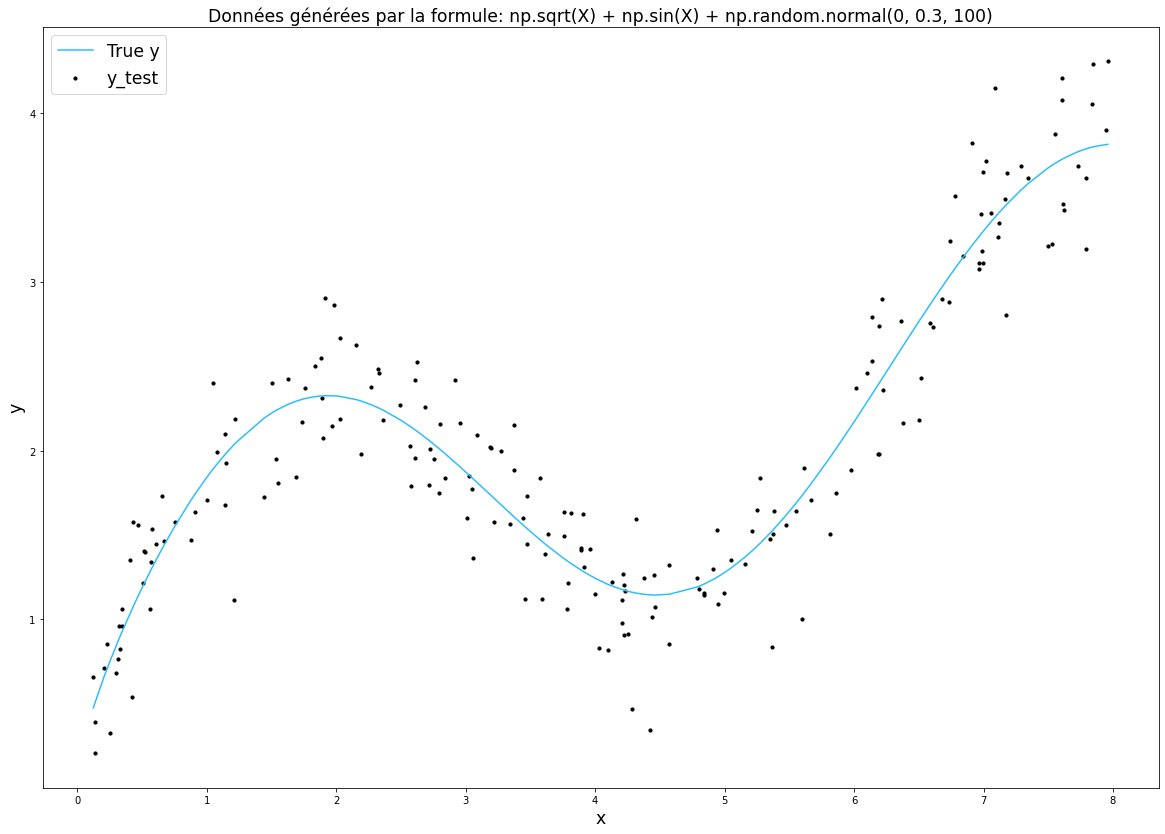

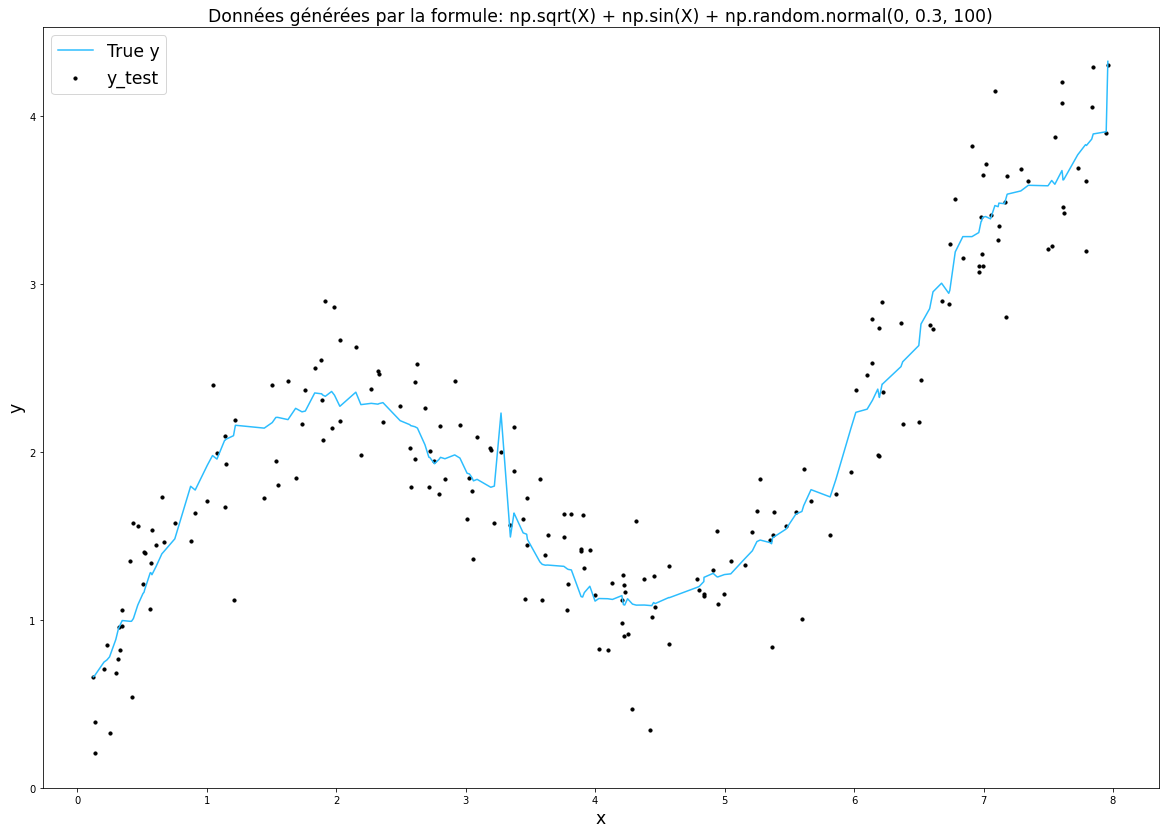

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X_test = np.random.uniform(0, 8, size = 200)
X_test = sorted(list(X_test))
mu, sigma = 0, 0.3
y_test = np.sqrt(X_test) + np.sin(X_test) + np.random.normal(mu, sigma, size = 200)
X_test, y_test = np.array(X_test), np.array(y_test)

fig, ax = plt.subplots(figsize=(20,14))
ax.scatter(X_test, y_test, color = 'black', s=10)
plt.plot(X_test, np.sqrt(X_test) + np.sin(X_test))
plt.legend(["True y", "y_test"], fontsize="xx-large")
plt.title('Données générées par la formule: np.sqrt(X) + np.sin(X) + np.random.normal(0, 0.3, 100)', fontsize="xx-large")
plt.xlabel('x', fontsize="xx-large")
plt.ylabel('y', fontsize="xx-large")

N=1
tab_agregated_estimator = []
tab_errors = []
tab_coefficients = []
for i in range(N):
  X_train = np.random.uniform(0, 8, size = 200)
  X_train = sorted(list(X_train))
  y_train = np.sqrt(X_train) + np.sin(X_train) + np.random.normal(mu, sigma, size = 200)
  X_train, y_train = np.array(X_train), np.array(y_train)
  tuple1 = mega_fonction(X_train, y_train, X_test, y_test)
  tab_agregated_estimator.append(tuple1[0])
  tab_errors.append(tuple1[1])
  tab_coefficients.append(tuple1[2])

aver_error = average_error(tab_errors)
aver_coefficients = average_error(tab_coefficients)
print("tableau des coefficients moyens :")
print(aver_coefficients)
print("tableau des erreurs moyennes :")
print(aver_error)
fig, ax = plt.subplots(figsize=(20,14))
ax.scatter(X_test, y_test, color = 'black', s=10)
plt.plot(X_test, tab_agregated_estimator[0])
plt.legend(["True y", "y_test"], fontsize="xx-large")
plt.title('Données générées par la formule: np.sqrt(X) + np.sin(X) + np.random.normal(0, 0.3, 100)', fontsize="xx-large")
plt.xlabel('x', fontsize="xx-large")
plt.ylabel('y', fontsize="xx-large")

#Test sur la fonction g(x) = cos(2x) + sin(2x) sur [0,8]

tableau des coefficients moyens :
[-0.051833748523242185, 0.06437595933979548, -0.044771616816111956, 0.5607730387057399, 1.347681379117027, -1.0558106419003097, 0.12549929599570936, -0.0014786975030543058, -0.04664977257534019]
tableau des erreurs moyennes :
[0.28135775367208304, 0.123147686306794, 0.11212268804865494, 0.10494358087518552, 0.231792230126888, 0.4890243642774291, 0.13651951526214157, 4.811923630520343, 0.17109557884420934, 0.09781951507933428]


Text(0, 0.5, 'y')

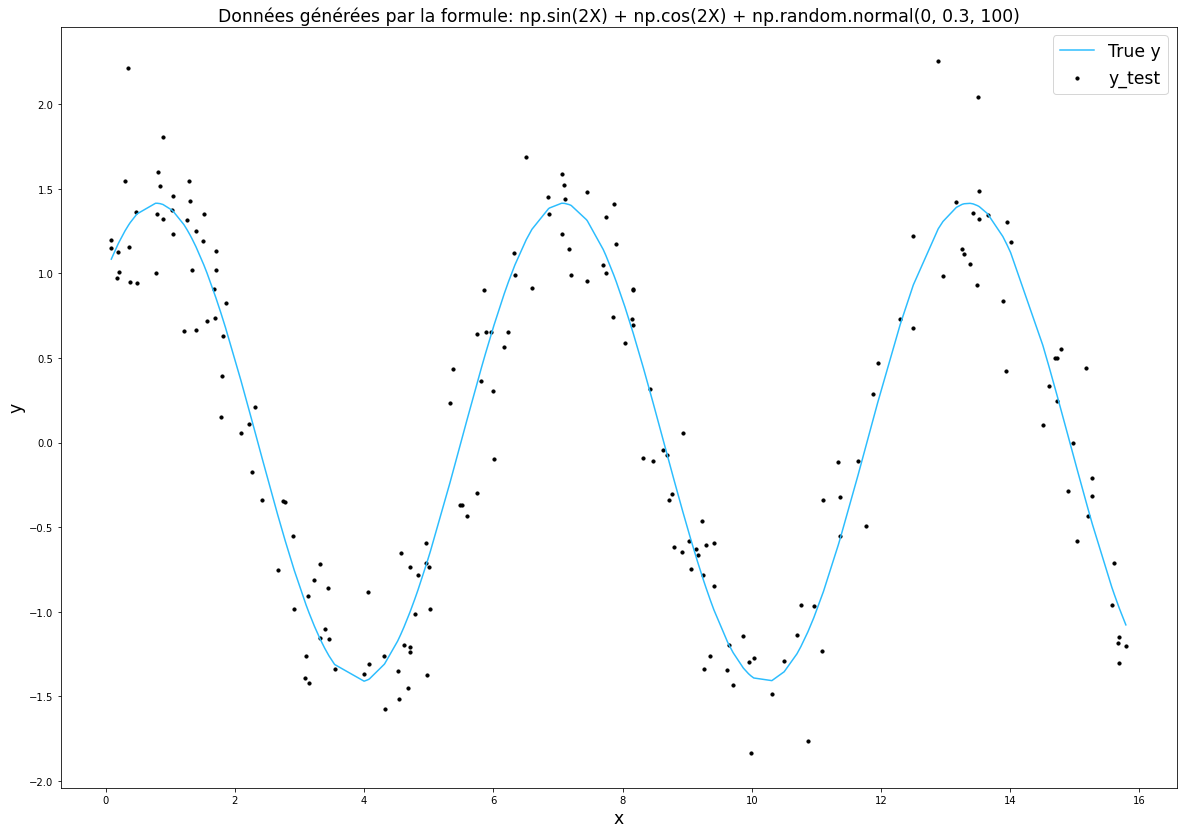

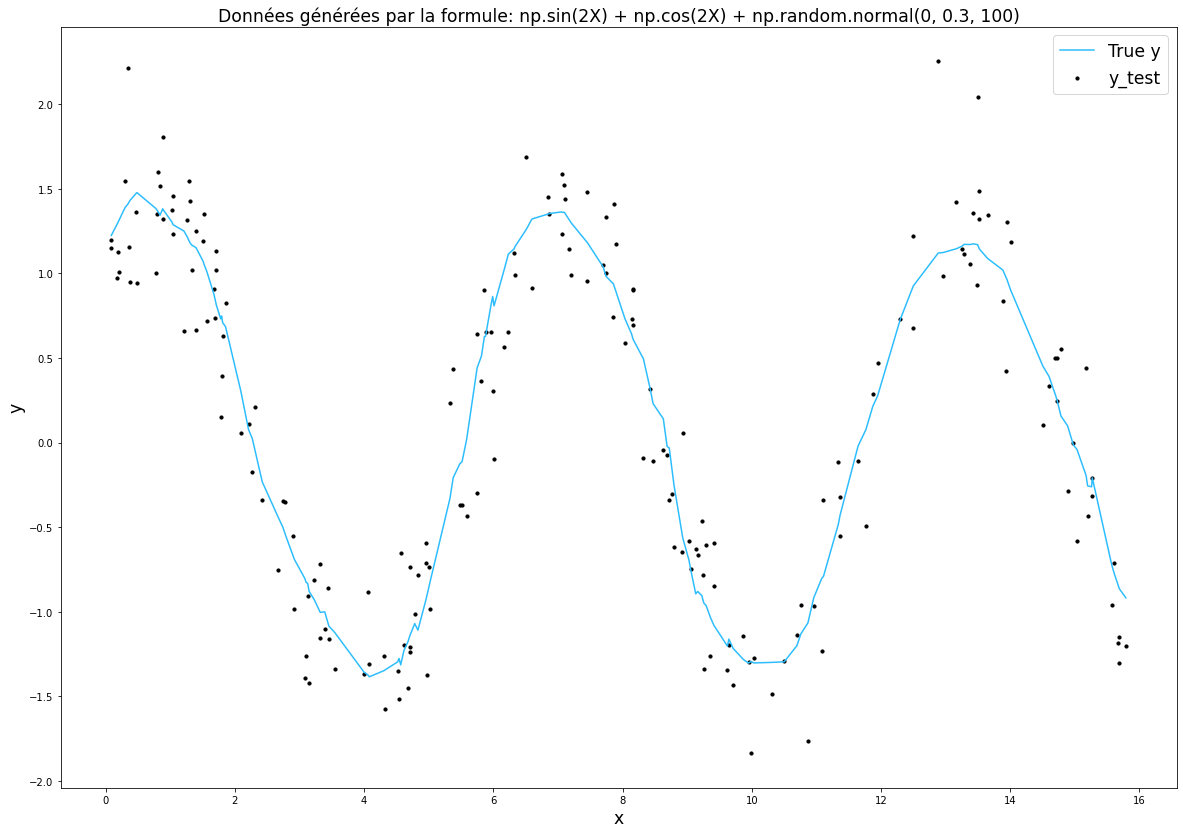

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X_test = np.random.uniform(0, 8, size = 200)
X_test = sorted(list(2 * X_test))
mu, sigma = 0, 0.3
y_test = np.cos(X_test) + np.sin(X_test) + np.random.normal(mu, sigma, size = 200)
X_test, y_test = np.array(X_test), np.array(y_test)

fig, ax = plt.subplots(figsize=(20,14))
ax.scatter(X_test, y_test, color = 'black', s=10)
plt.plot(X_test, np.cos(X_test) + np.sin(X_test))
plt.legend(["True y", "y_test"], fontsize="xx-large")
plt.title('Données générées par la formule: np.sin(2X) + np.cos(2X) + np.random.normal(0, 0.3, 100)', fontsize="xx-large")
plt.xlabel('x', fontsize="xx-large")
plt.ylabel('y', fontsize="xx-large")


N=10
tab_agregated_estimator = []
tab_errors = []
tab_coefficients = []
for i in range(N):
  X_train = np.random.uniform(0, 8, size = 200)
  X_train = sorted(list(2 * X_train))
  y_train = np.cos(X_train) + np.sin(X_train) + np.random.normal(mu, sigma, size = 200)
  X_train, y_train = np.array(X_train), np.array(y_train)
  tuple1 = mega_fonction(X_train, y_train, X_test, y_test)
  tab_agregated_estimator.append(tuple1[0])
  tab_errors.append(tuple1[1])
  tab_coefficients.append(tuple1[2])


aver_error = average_error(tab_errors)
aver_coefficients = average_error(tab_coefficients)
print("tableau des coefficients moyens :")
print(aver_coefficients)
print("tableau des erreurs moyennes :")
print(aver_error)
fig, ax = plt.subplots(figsize=(20,14))
ax.scatter(X_test, y_test, color = 'black', s=10)
plt.plot(X_test, tab_agregated_estimator[0])
plt.legend(["True y", "y_test"], fontsize="xx-large")
plt.title('Données générées par la formule: np.sin(2X) + np.cos(2X) + np.random.normal(0, 0.3, 100)', fontsize="xx-large")
plt.xlabel('x', fontsize="xx-large")
plt.ylabel('y', fontsize="xx-large")



#Test sur la fonction g(x) = E(x) sur [0,8], où E(.) est la partie entière par excès

tableau des coefficients moyens :
[-0.20393700099221918, 0.7305131326148251, 0.13009384922089406, 0.3676302602099949, 0.1294014233705383, -0.02487214558068029, -0.101596745033774, 0.0012668175518957133, 0.08749866987036123]
tableau des erreurs moyennes :
[0.06614737454624939, 0.03321980969765472, 0.048754383240952846, 0.03795263068293602, 0.1596239136266662, 0.3566247561483153, 0.3955819116472811, 2718.00264928007, 0.5636407821846958, 0.02841384951348673]


Text(0, 0.5, 'y')

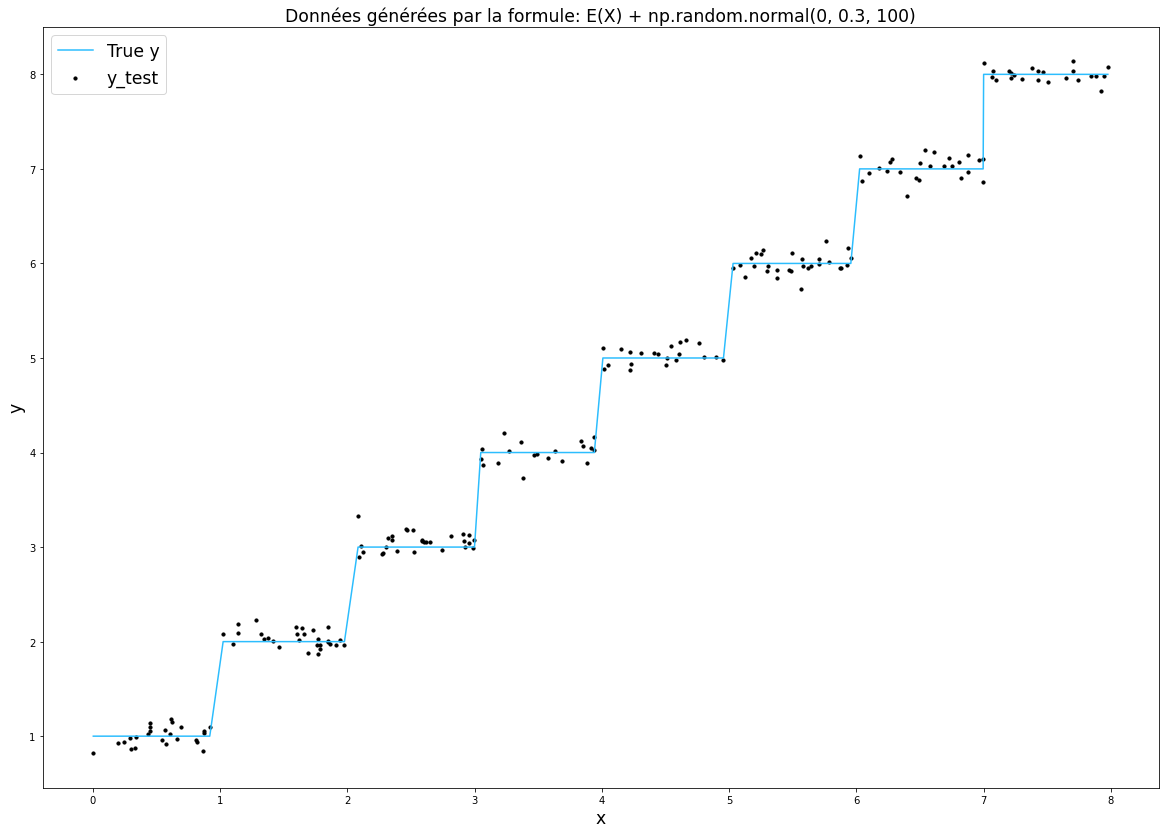

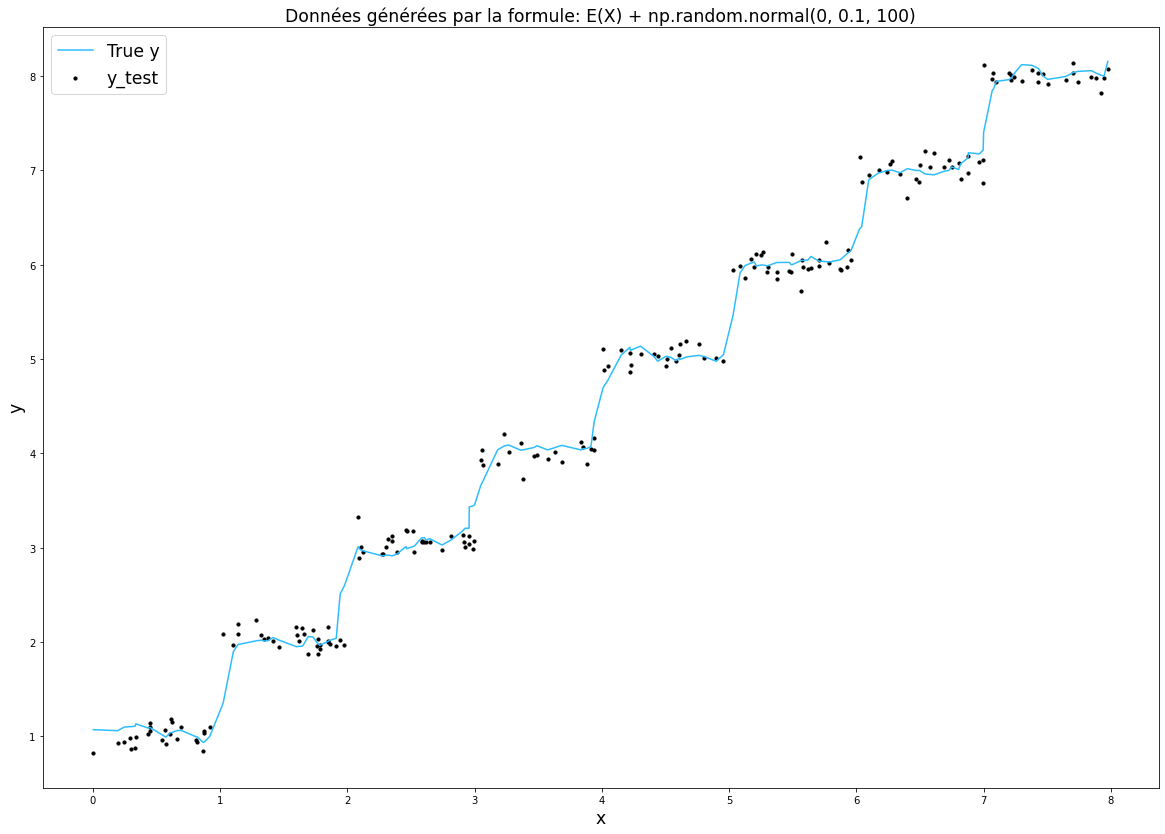

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def ceiling(X):
  tab = []
  for i in range(len(X)):
    tab.append(math.ceil(X[i]))
  return tab


X_test = np.random.uniform(0, 8, size = 200)
X_test = sorted(list(X_test))
mu, sigma = 0, 0.1
y_test = ceiling(X_test) + np.random.normal(mu, sigma, size = 200)
X_test, y_test = np.array(X_test), np.array(y_test)

fig, ax = plt.subplots(figsize=(20,14))
ax.scatter(X_test, y_test, color = 'black', s=10)
plt.plot(X_test, ceiling(X_test))
plt.legend(["True y", "y_test"], fontsize="xx-large")
plt.title('Données générées par la formule: E(X) + np.random.normal(0, 0.3, 100)', fontsize="xx-large")
plt.xlabel('x', fontsize="xx-large")
plt.ylabel('y', fontsize="xx-large")


N=10
tab_agregated_estimator = []
tab_errors = []
tab_coefficients = []
for i in range(N):
  X_train = np.random.uniform(0, 8, size = 200)
  X_train = sorted(list(X_train))
  y_train = ceiling(X_train) + np.random.normal(mu, sigma, size = 200)
  X_train, y_train = np.array(X_train), np.array(y_train)
  tuple1 = mega_fonction(X_train, y_train, X_test, y_test)
  tab_agregated_estimator.append(tuple1[0])
  tab_errors.append(tuple1[1])
  tab_coefficients.append(tuple1[2])


aver_error = average_error(tab_errors)
aver_coefficients = average_error(tab_coefficients)
print("tableau des coefficients moyens :")
print(aver_coefficients)
print("tableau des erreurs moyennes :")
print(aver_error)
fig, ax = plt.subplots(figsize=(20,14))
ax.scatter(X_test, y_test, color = 'black', s=10)
plt.plot(X_test, tab_agregated_estimator[0])
plt.legend(["True y", "y_test"], fontsize="xx-large")
plt.title('Données générées par la formule: E(X) + np.random.normal(0, 0.1, 100)', fontsize="xx-large")
plt.xlabel('x', fontsize="xx-large")
plt.ylabel('y', fontsize="xx-large")

#Tests d'approximation de la densité d'une loi normale avec différents estimateurs à noyau (espérance = 0, variance = 2)

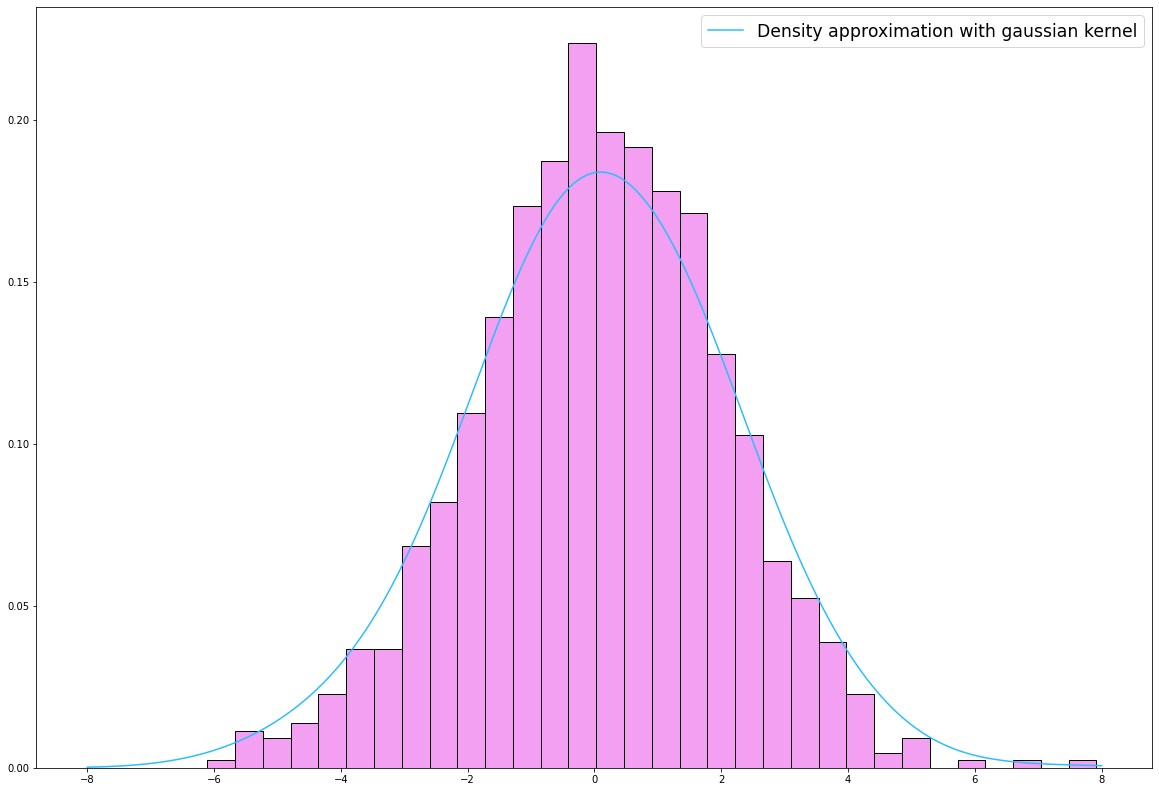

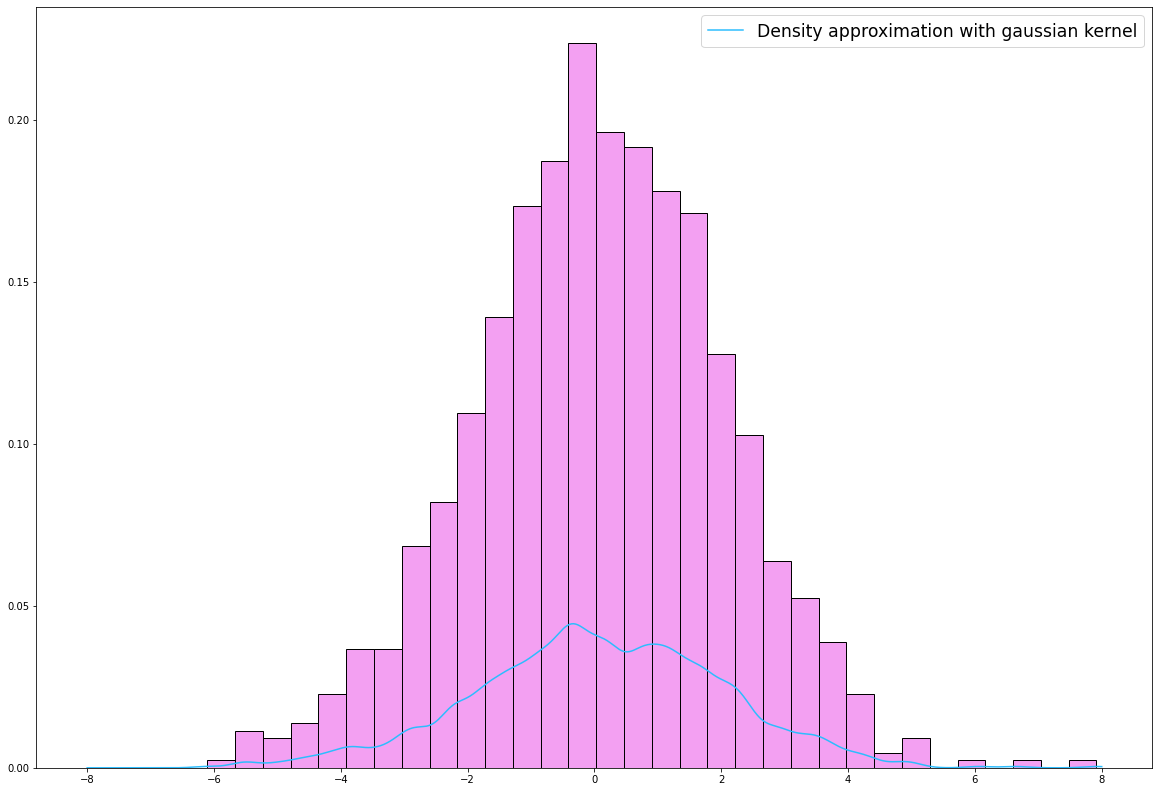

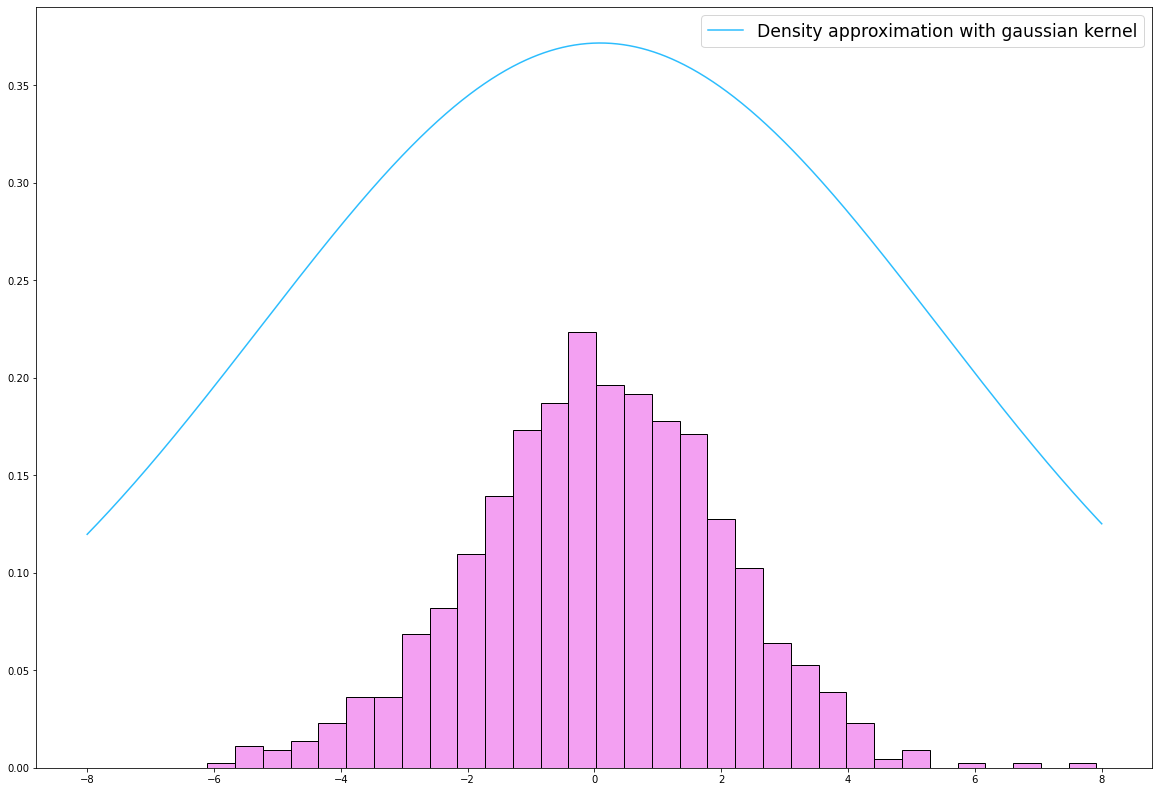

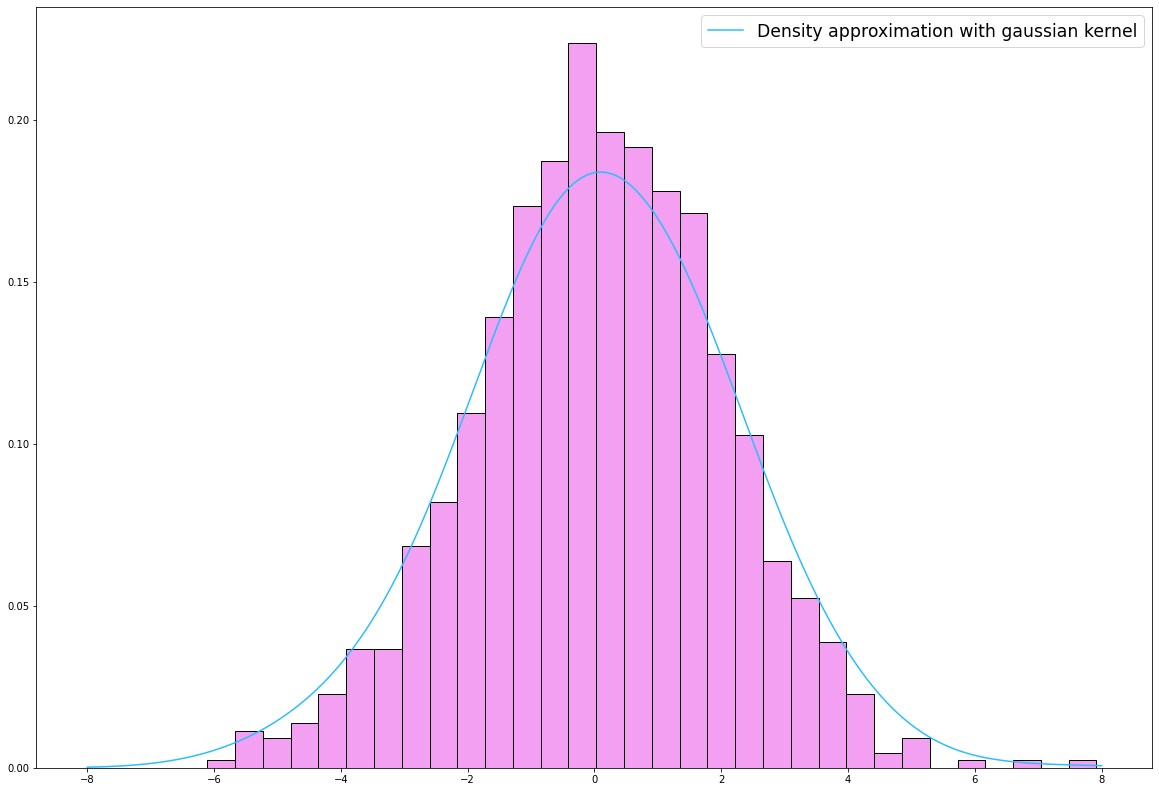

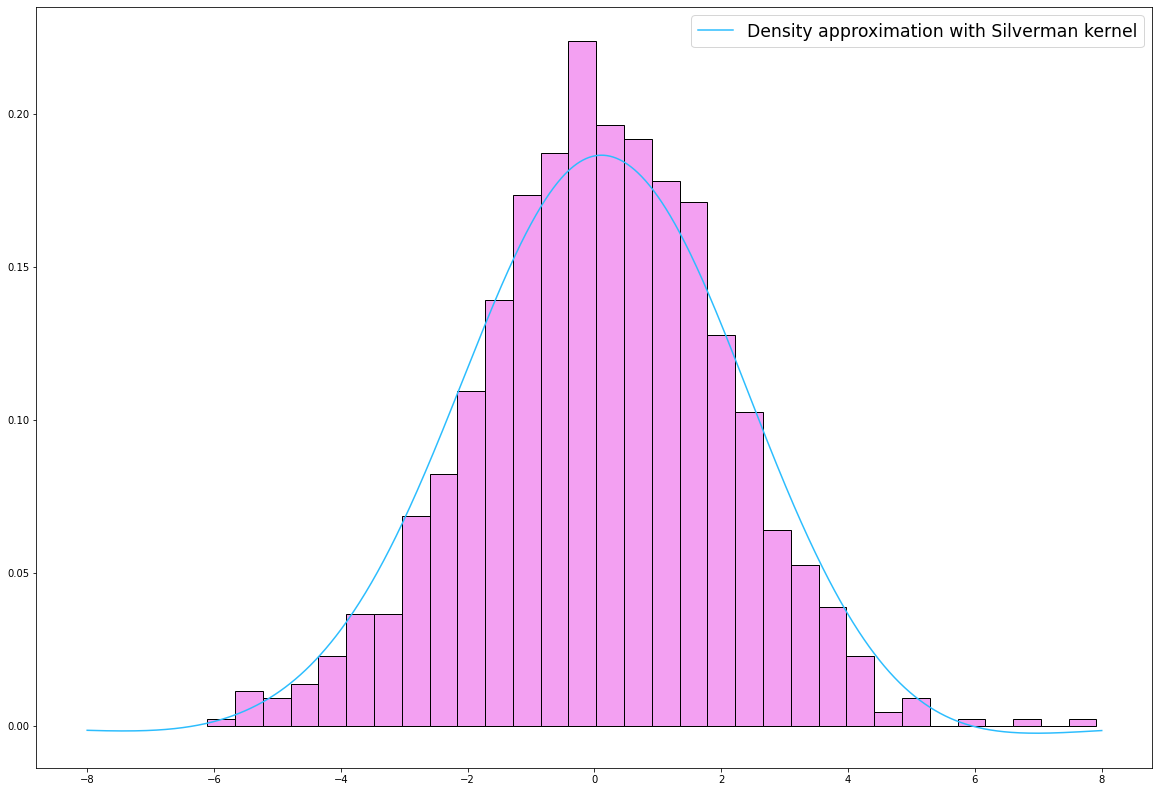

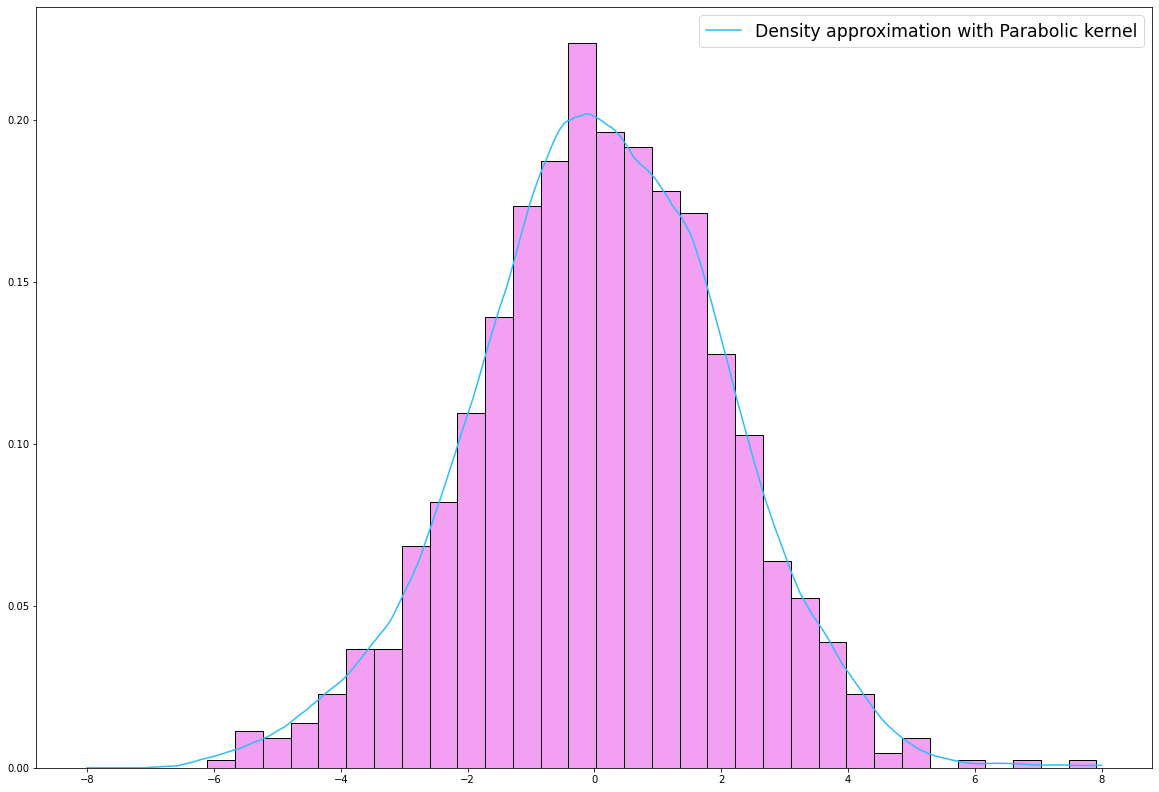

In [ ]:

import math
import matplotlib as mpl

#numero : 1
def gaussian_kernel(x):
  return((1/(math.sqrt(2*math.pi)))*math.exp(-0.5*x**2))

#numero : 2
def silverman_kernel(x):
  res = 0.5 * math.exp(- math.fabs(x) / np.sqrt(2)) * np.sin( (math.fabs(x) / np.sqrt(2)) + (math.pi/4) )
  return res

#numero : 3
def parabolic_kernel(u):
  if ((u >= -1) & (u <= 1)):
    return (0.75 * (1 - (u**2) ))
  return 0

def choice_kernel(x, kernel):
  if (kernel == 1):
    return gaussian_kernel(x)
  elif (kernel == 2):
    return silverman_kernel(x)
  elif (kernel == 3):
    return parabolic_kernel(x)


def estimateur_densite_noyau(Y_app, X_test, bandwidth, kernel):
  estimator = []
  for i in X_test:
    sum_x = 0
    for j in range(len(Y_app)):
      sum_x = sum_x + (1/len(Y_app))*choice_kernel( (i-Y_app[j])/bandwidth, kernel)
    estimator.append(sum_x)
  return estimator

mu, sigma = 0, 2
X_test = np.linspace(-4*sigma, 4*sigma, 1000)
Y_app = np.random.normal(mu, sigma, 1000)

#test1
kernel = 1
bandwidth = 1
estimator = estimateur_densite_noyau(Y_app, X_test, bandwidth, kernel)
w = 0.5
n = math.ceil((X_test.max() - X_test.min())/w)
fig, ax = plt.subplots(figsize=(20,14))
plt.plot(X_test, estimator)
plt.hist(Y_app, bins = n, edgecolor = 'black', density=True)
plt.legend(["Density approximation with gaussian kernel"], fontsize="xx-large")

#test2
kernel = 1
bandwidth = 0.2
estimator = estimateur_densite_noyau(Y_app, X_test, bandwidth, kernel)
w = 0.5
n = math.ceil((X_test.max() - X_test.min())/w)
fig, ax = plt.subplots(figsize=(20,14))
plt.plot(X_test, estimator)
plt.hist(Y_app, bins = n, edgecolor = 'black', density=True)
plt.legend(["Density approximation with gaussian kernel"], fontsize="xx-large")

#test3
kernel = 1
bandwidth = 5
estimator = estimateur_densite_noyau(Y_app, X_test, bandwidth, kernel)
w = 0.5
n = math.ceil((X_test.max() - X_test.min())/w)
fig, ax = plt.subplots(figsize=(20,14))
plt.plot(X_test, estimator)
plt.hist(Y_app, bins = n, edgecolor = 'black', density=True)
plt.legend(["Density approximation with gaussian kernel"], fontsize="xx-large")

#test4
kernel = 1
bandwidth = 1
estimator = estimateur_densite_noyau(Y_app, X_test, bandwidth, kernel)
w = 0.5
n = math.ceil((X_test.max() - X_test.min())/w)
fig, ax = plt.subplots(figsize=(20,14))
plt.plot(X_test, estimator)
plt.hist(Y_app, bins = n, edgecolor = 'black', density=True)
plt.legend(["Density approximation with gaussian kernel"], fontsize="xx-large")

#test5
kernel = 2
bandwidth = 1
estimator = estimateur_densite_noyau(Y_app, X_test, bandwidth, kernel)
w = 0.5
n = math.ceil((X_test.max() - X_test.min())/w)
fig, ax = plt.subplots(figsize=(20,14))
plt.plot(X_test, estimator)
plt.hist(Y_app, bins = n, edgecolor = 'black', density=True)
plt.legend(["Density approximation with Silverman kernel"], fontsize="xx-large")

#test6
kernel = 3
bandwidth = 1
estimator = estimateur_densite_noyau(Y_app, X_test, bandwidth, kernel)
w = 0.5
n = math.ceil((X_test.max() - X_test.min())/w)
fig, ax = plt.subplots(figsize=(20,14))
plt.plot(X_test, estimator)
plt.hist(Y_app, bins = n, edgecolor = 'black', density=True)
plt.legend(["Density approximation with Parabolic kernel"], fontsize="xx-large")

#Tests d'approximation de la densité d'une loi normale avec différents estimateurs par projection (espérance = 0, variance = 2)

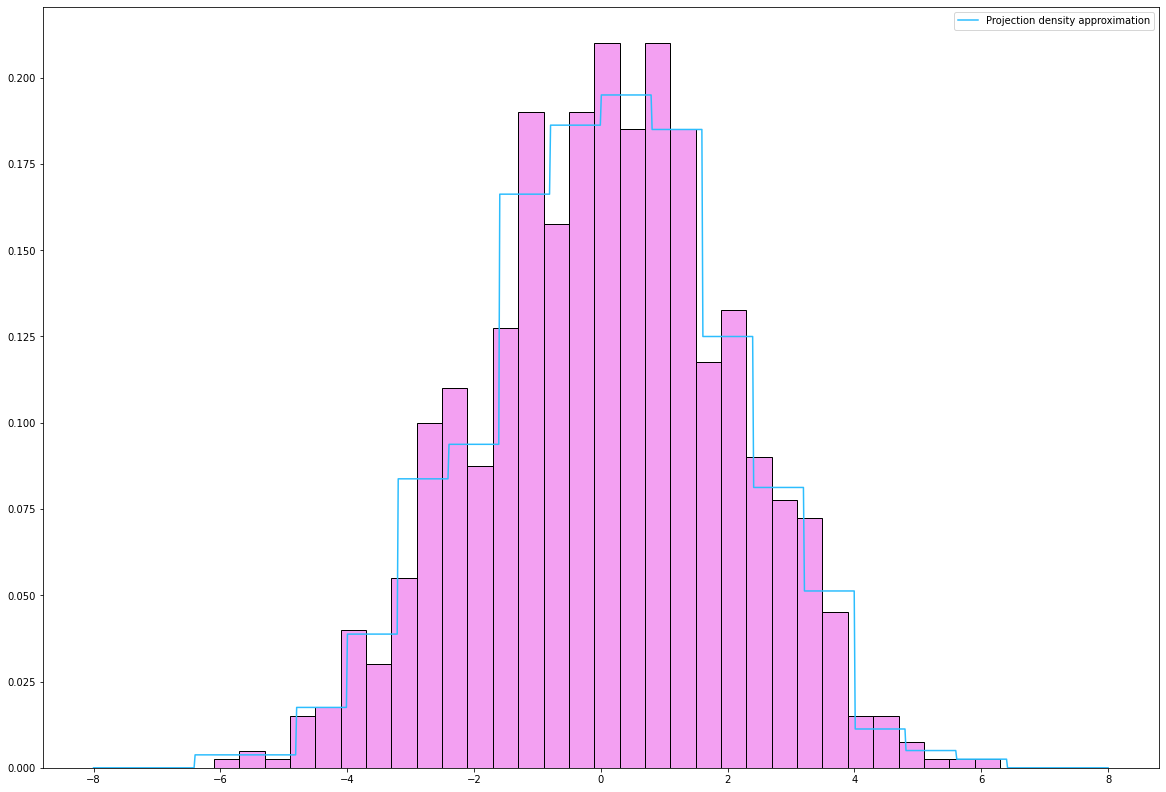

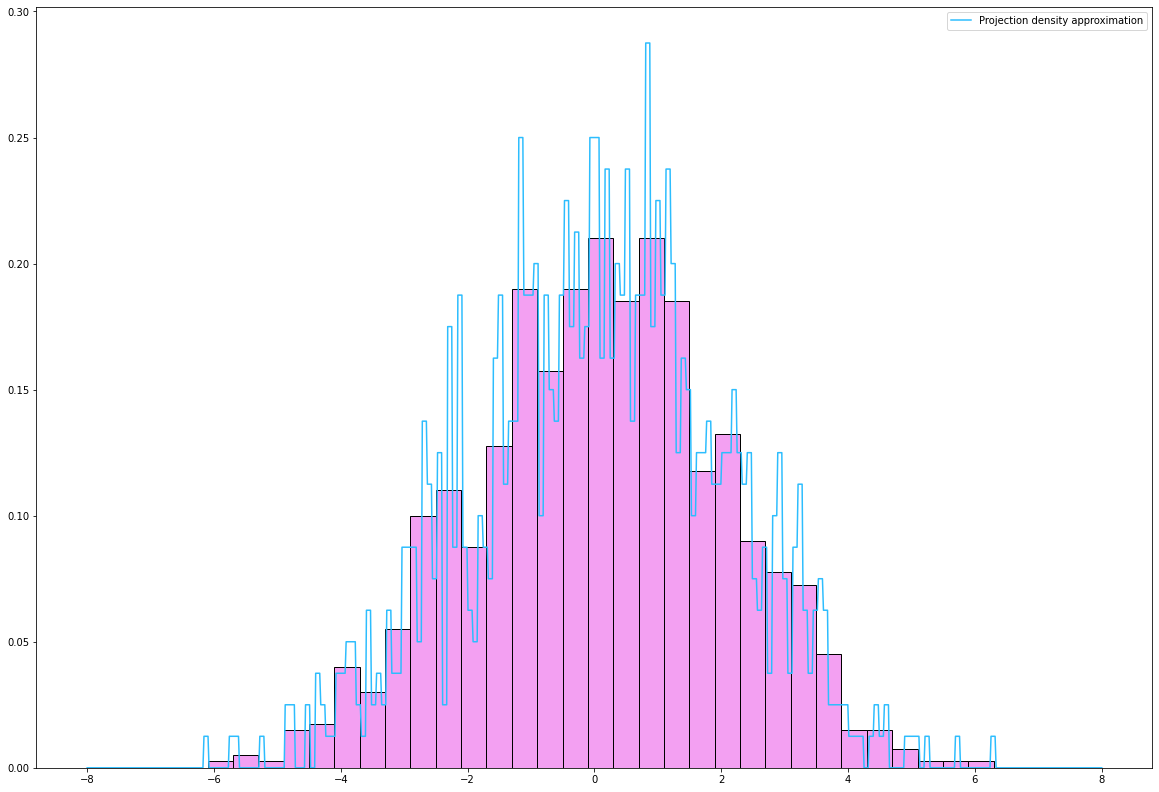

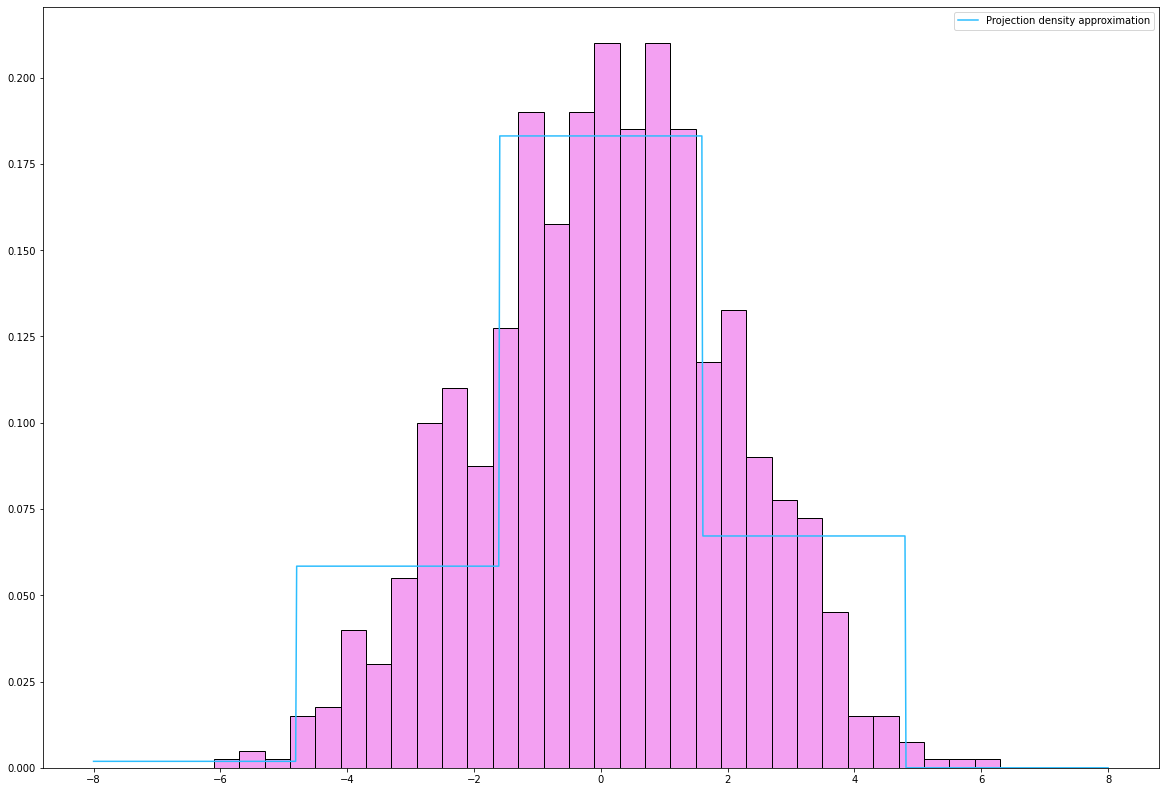

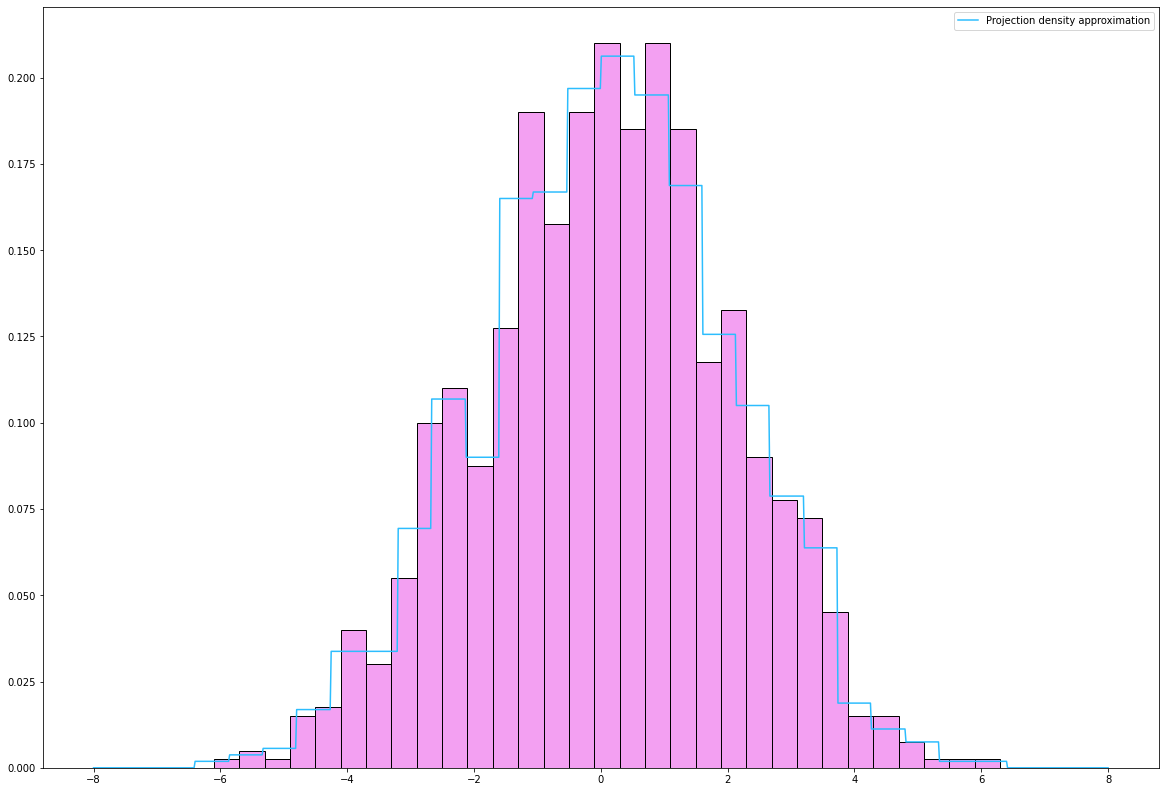

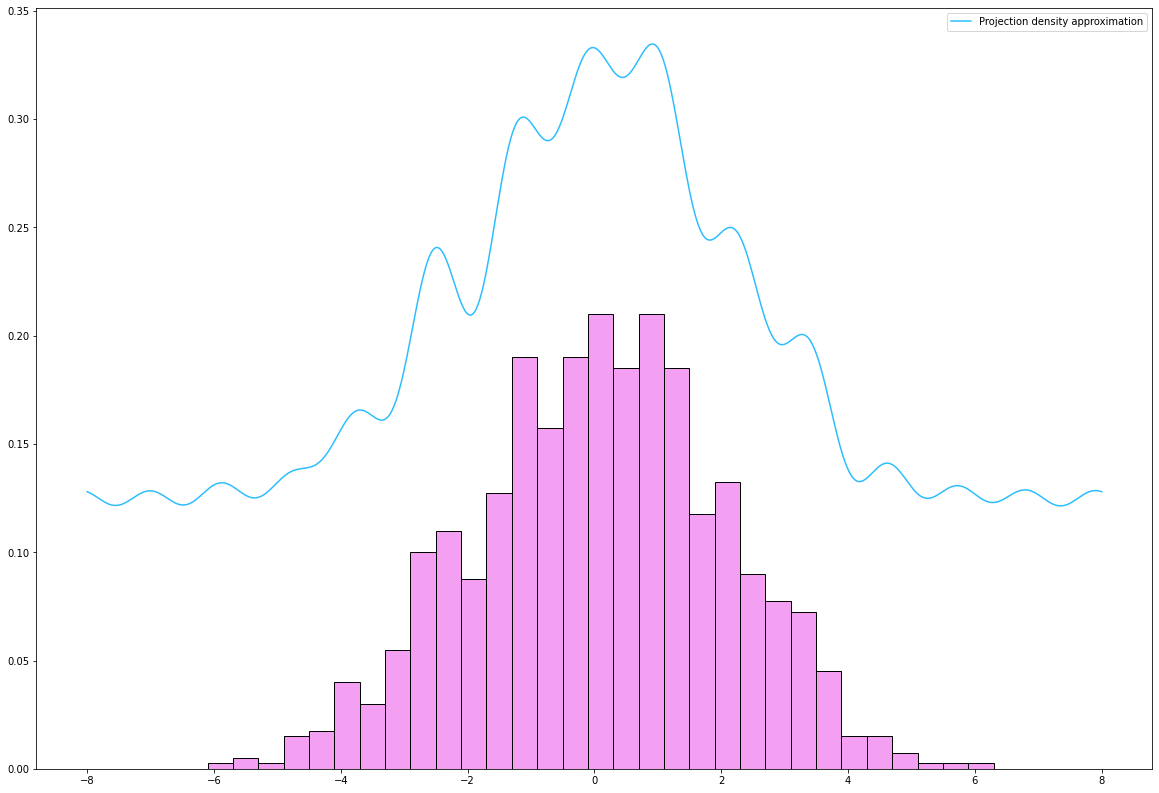

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl


def estimateur_densite_projection(Y_app, X_test, D, base):
  A = []
  a = min(X_test)
  b = max(X_test)
  n = len(Y_app)
  for j in range(D):
    const = 0
    for i in range(n):
      const = const + choice_base(Y_app[i], j, a, b, D, base) 
    A.append(const/n)
  estimateur = []
  for i in range(len(X_test)):
    est = 0
    for j in range(D):
      est = est + (A[j] * choice_base(X_test[i], j, a, b, D, base))
    estimateur.append(est)
  return estimateur


mu, sigma = 0, 2
X_test = np.linspace(-4*sigma, 4*sigma, 1000)
Y_app = np.random.normal(mu, sigma, 1000)

#test1
D = 20
base = 1
estimator = estimateur_densite_projection(Y_app, X_test, D, base)
w = 0.4
n = math.ceil((Y_app.max() - Y_app.min())/w)
fig, ax = plt.subplots(figsize=(20,14))
plt.plot(X_test, estimator)
plt.hist(Y_app, bins = n, edgecolor = 'black', density=True)
plt.legend(["Projection density approximation"])


#test2
D = 200
base = 1
estimator = estimateur_densite_projection(Y_app, X_test, D, base)
w = 0.4
n = math.ceil((Y_app.max() - Y_app.min())/w)
fig, ax = plt.subplots(figsize=(20,14))
plt.plot(X_test, estimator)
plt.hist(Y_app, bins = n, edgecolor = 'black', density=True)
plt.legend(["Projection density approximation"])

#test3
D = 5
base = 1
estimator = estimateur_densite_projection(Y_app, X_test, D, base)
w = 0.4
n = math.ceil((Y_app.max() - Y_app.min())/w)
fig, ax = plt.subplots(figsize=(20,14))
plt.plot(X_test, estimator)
plt.hist(Y_app, bins = n, edgecolor = 'black', density=True)
plt.legend(["Projection density approximation"])


#test4
D = 30
base = 1
estimator = estimateur_densite_projection(Y_app, X_test, D, base)
w = 0.4
n = math.ceil((Y_app.max() - Y_app.min())/w)
fig, ax = plt.subplots(figsize=(20,14))
plt.plot(X_test, estimator)
plt.hist(Y_app, bins = n, edgecolor = 'black', density=True)
plt.legend(["Projection density approximation"])

#test5
D = 30
base = 2
estimator = estimateur_densite_projection(Y_app, X_test, D, base)
w = 0.4
n = math.ceil((Y_app.max() - Y_app.min())/w)
fig, ax = plt.subplots(figsize=(20,14))
plt.plot(X_test, estimator)
plt.hist(Y_app, bins = n, edgecolor = 'black', density=True)
plt.legend(["Projection density approximation"])